In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io.arff import loadarff 

#Funções de avaliação dos modelos
from sklearn.metrics import (
    classification_report,
    plot_confusion_matrix,
    plot_roc_curve,
    accuracy_score,
)
from sklearn.model_selection import(
    train_test_split, 
    cross_val_predict,
    KFold,
)

#utils
from utils.num import Num
# from utils.run_models import RunModels

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Classes do modelo de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn import svm

In [16]:
class RunModels:
    
    def __init__(self, models: dict) -> None:
        self.models = models
        self.scores = dict()
    
    def load_data(self, X_train: pd.DataFrame, X_test: pd.Series,
                  y_train: pd.DataFrame, y_test: pd.Series) -> None:
        self.X_train, self.X_test = X_train, X_test
        self.y_train, self.y_test = y_train, y_test

    def train(self) -> None:
        self.trained_models = dict()
        self.preds = dict()

        for name, model in self.models.items():
            self.trained_models[name] = model.fit(self.X_train, self.y_train)
            self.preds[name] = model.predict(self.X_test)
    
    def accuracy(self) -> None:
        for model in self.models.keys():
            self.scores[model] = self.trained_models[model].score(
                self.X_test,
                self.y_test,
            )
    
    def get_accuracy(self, models: list[str] = None) -> dict:
        if not models:
            models = self.models.keys()

        models_acc = dict()
        for model in models:
            models_acc[model] = self.scores[model]
        
        return models_acc

    def report(self, models: list[str] = None) -> None:
        if not models:
            models = self.models.keys()

        for model in models:
            print(model + '\n')
            print(classification_report(self.y_test, self.preds[model]))
        

In [4]:
raw_data = loadarff('mnist_784.arff')
df = pd.DataFrame(raw_data[0])

<BarContainer object of 10 artists>

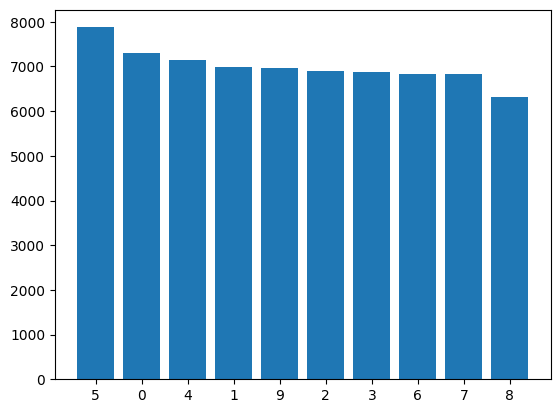

In [5]:
plt.bar(x = df['class'].unique(), height = df['class'].value_counts())

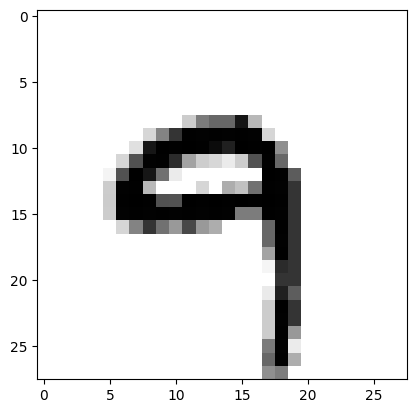

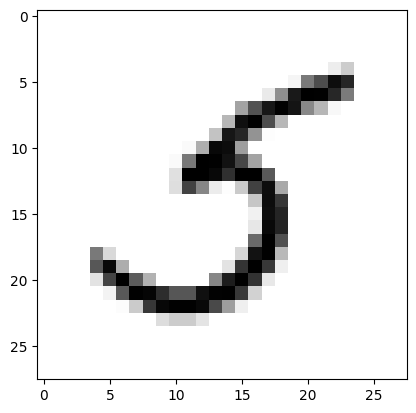

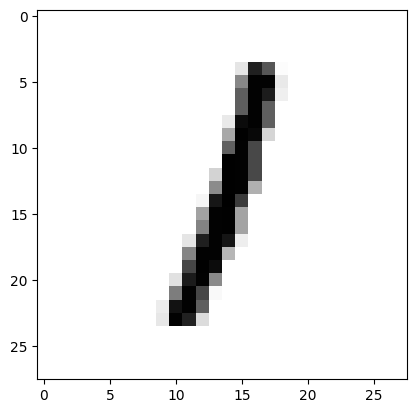

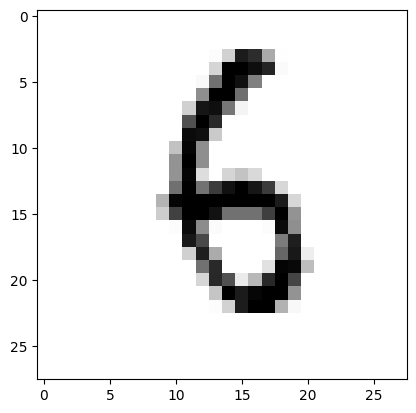

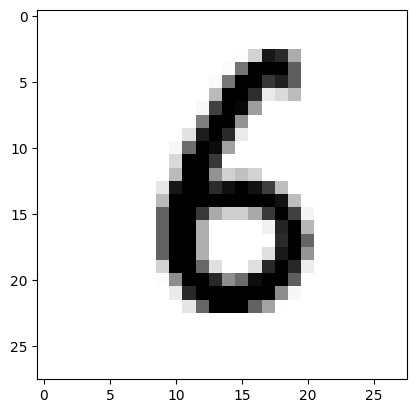

In [6]:
# Visualizando algumas instância do dataset

nums = df['class'].unique()

for i in np.random.randint(1000, size=5):
    rnd_choice = np.random.choice(nums)
    p = pd.array(
        df[df['class'] == rnd_choice].iloc[i][:-1],
        dtype=int,
    ).reshape((28,28))

    plt.imshow(p, cmap='gray_r', vmin=0, vmax=255)
    plt.show()

In [13]:
# Separando dataset

X = df.iloc[:, 0:-1]
y = df.iloc[:, [-1]].astype('int') # target

kf = KFold(n_splits=5)
fold = 0

# Treinando os modelos

run = RunModels(
    {
        'KNN': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'GaussianNB': GaussianNB(),
        'MultinomialNB': MultinomialNB(),
        # 'Perceptron': Perceptron(),
        # 'MLP': MLPClassifier(),
        # 'SVM': svm.SVC(),
    }
)

trained_models = dict()
for train, test in kf.split(X,y):
    run.load_data(X.iloc[train], X.iloc[test],
                  y.iloc[train], y.iloc[test])
    run.train()

    trained_models[f'fold_{fold}'] = run

    print(f'Fold {fold}: {run.accuracy()}')
    fold += 1

Fold 0: {'KNN': 0.9699285714285715, 'Decision Tree': 0.8702857142857143, 'GaussianNB': 0.5553571428571429, 'MultinomialNB': 0.8215}
Fold 1: {'KNN': 0.9709285714285715, 'Decision Tree': 0.8725, 'GaussianNB': 0.5625, 'MultinomialNB': 0.8169285714285714}
Fold 2: {'KNN': 0.9707142857142858, 'Decision Tree': 0.864, 'GaussianNB': 0.5545714285714286, 'MultinomialNB': 0.8220714285714286}
Fold 3: {'KNN': 0.9658571428571429, 'Decision Tree': 0.8695, 'GaussianNB': 0.5466428571428571, 'MultinomialNB': 0.8219285714285715}
Fold 4: {'KNN': 0.9714285714285714, 'Decision Tree': 0.8802857142857143, 'GaussianNB': 0.5627142857142857, 'MultinomialNB': 0.8457857142857143}


In [14]:
acc = list()
for fold in trained_models.values():
    knn_acc = fold.accuracy(['KNN'])
    acc.append(knn_acc)
    print(knn_acc)
    

{'KNN': 0.9714285714285714}
{'KNN': 0.9714285714285714}
{'KNN': 0.9714285714285714}
{'KNN': 0.9714285714285714}
{'KNN': 0.9714285714285714}


## Brincando com nossos números

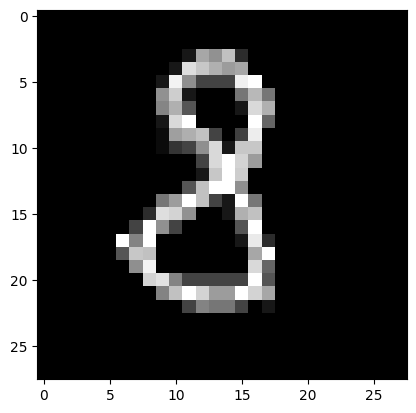

array([3])

In [ ]:
# Testando número
num = Num('imgs/oito.png', invert=True)
num.plot()
run.models['KNN'].predict(num.to_array())